In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
#creating inspector to get the columns and their type
inspector = inspect(engine)
#getting columns and type for measurement
mColumns = inspector.get_columns('Measurement')
for c in mColumns:
    print(c["name"], c["type"])

print("-"*15)
#getting columns and type for station
sColumns = inspector.get_columns('Station')
for c in sColumns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
recentDate = session.query(func.max(Measurement.date)).first()
recentDate

('2017-08-23',)

Text(0.5, 0, 'Date')

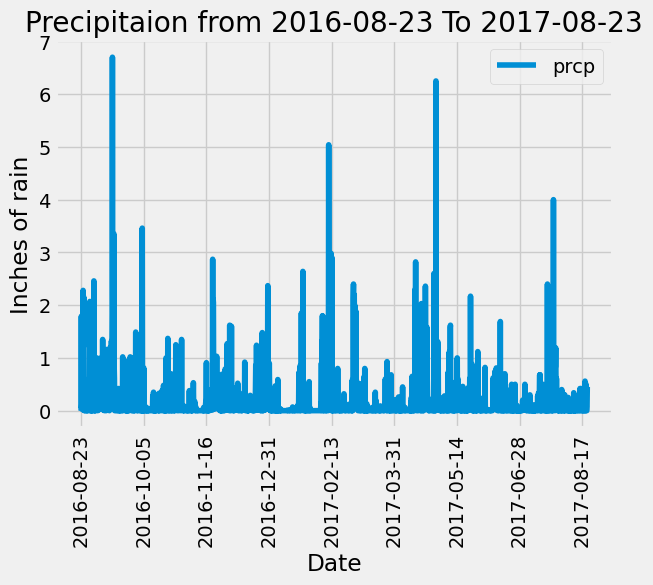

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
mostRecentDate = dt.datetime.strptime(recentDate[0], '%Y-%m-%d')

oneYearBeforeDate = mostRecentDate - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
recentYearData = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= oneYearBeforeDate).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(recentYearData)

# Sort the dataframe by date
sorted_df = prcp_df.sort_values("date")
#Setting new index as date
index_df = sorted_df.set_index("date")
#dropping the null values
final_df = index_df.dropna(axis=0)

# Use Pandas Plotting with Matplotlib to plot the data
final_df.plot()
plt.xticks(rotation="vertical")
plt.title("Precipitaion from 2016-08-23 To 2017-08-23")
plt.ylabel("Inches of rain")
plt.xlabel("Date")


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
final_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
totalStations = session.query(Station.station).count()
totalStations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activeStations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
activeStations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostActive = activeStations[0][0]

#Lowest temp
lowTemp = session.query(func.min(Measurement.tobs).filter(Measurement.station == mostActive)).all()
print(f"Lowest Temp {lowTemp}")

#Highest temp
highTemp = session.query(func.max(Measurement.tobs).filter(Measurement.station == mostActive)).all()
print(f"Highest Temp {highTemp}")

#Average Temp
avgTemp = session.query(func.avg(Measurement.tobs).filter(Measurement.station == mostActive)).all()
print(f"AverageTemp {avgTemp}")


Lowest Temp [(54.0,)]
Highest Temp [(85.0,)]
AverageTemp [(71.66378066378067,)]


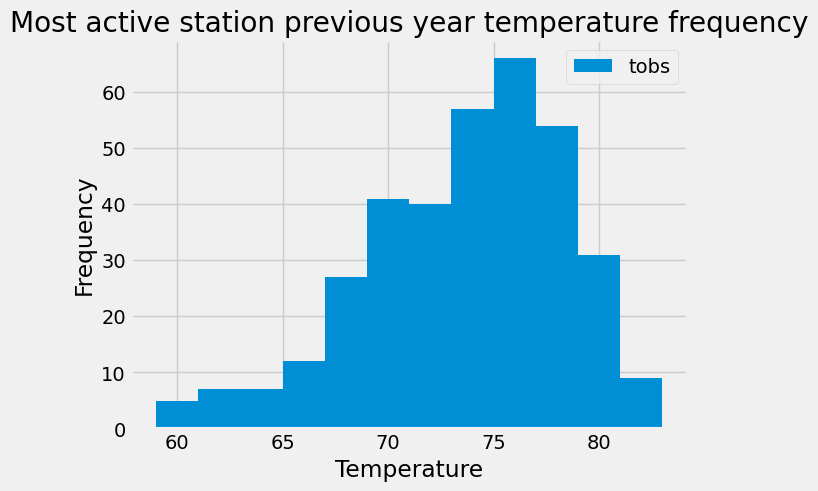

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#getting most recent date for station
stationRecentDate = session.query(func.max(Measurement.date).filter(Measurement.station == mostActive)).first()
stationRecentDate1 = dt.datetime.strptime(stationRecentDate[0], '%Y-%m-%d')
#Getting one year before most recent date
yearStationDate = stationRecentDate1 - dt.timedelta(days = 365)
#query for tobs in the past year
yearStationData = session.query(Measurement.tobs).filter(Measurement.station == mostActive).filter(Measurement.date >= yearStationDate).all()
#creating data frame
station_df = pd.DataFrame(yearStationData)
#Creating graph
plt.hist(station_df, bins=12)
plt.title("Most active station previous year temperature frequency")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(station_df)

# Close Session

In [17]:
# Close Session
session.close()